<a href="https://colab.research.google.com/github/reckoning-machines/oil_betas/blob/master/sec_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# why use R here?  
# edgarWebR pulls sections really well

!git clone https://github.com/reckoning-machines/sec_test.git
!cp "sec_test/test_ticker_list.csv" "test_ticker_list.csv"


fatal: destination path 'sec_test' already exists and is not an empty directory.


In [2]:
# activate R magic
import rpy2
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
%%R

devtools::install_github("mwaldstein/edgarWebR")
devtools::install_github("r-lib/xml2") #this for edgarWebR 
devtools::install_github("DavisVaughan/furrr")

library(edgarWebR) #this is an up to date library with an active maintainer.
library(xml2)
library(knitr)
library(dplyr)
library(purrr)
library(rvest)
library(tidyr)
library(readr)
#library(textclean)
library(furrr)

LOGFILE = format(Sys.time(), "%b_%d_%Y.log")
print(LOGFILE)

CSVFILE = format(Sys.time(), "%b_%d_%Y.csv")
print(CSVFILE)

get_filings_links <-function(str_ticker) {
    df_filings <- company_filings(str_ticker, type = "10-", count = 20)
    df_filings <- df_filings[df_filings$type == "10-K" | df_filings$type == "10-Q", ]
    df_filing_infos <- map_df(df_filings$href, filing_information)
    df_filings <- bind_cols(df_filings, df_filing_infos)
    return(head(as_tibble(df_filings),20))
  }

write_log <- function(str_text) {
      print(str_text)
      if (file.exists(LOGFILE)) {
          write(str_text,file=LOGFILE,append=TRUE)
      } else {
          write(str_text,file=LOGFILE,append=FALSE)
      }

  }

write_log_csv <- function(df) {
    if (file.exists(CSVFILE)) {
          write_csv(df,CSVFILE,append=TRUE)
      } else {
          write_csv(df,CSVFILE,append=FALSE)
      }

  }

get_mdna_text <- function(str_href) {
  write_log("next link:")
  write_log(str_href)

  #make this a func
  str_file_path <- ''
  file_path = strsplit(str_href,'/')
  for (i in 5:length(file_path[[1]])-1) {
    str_file_path = paste0(str_file_path,"/",(file_path[[1]][i]))
  }
  str_file_path <- paste0(getwd(),"/",str_file_path)
  dir.create(str_file_path,recursive = TRUE)
  str_file_path
  str_file_name <- ''
  file_path = strsplit(str_href,'/')
  for (i in 4:length(file_path[[1]])) {
    str_file_name = paste0(str_file_name,"/",(file_path[[1]][i]))
  }
  str_file_name <- paste0(getwd(),str_file_name)
  str_file_name <- gsub(".htm",".csv",str_file_name)
  
  str_section = 'item 2|item 7'
  str_search = 'discussion'

  if (file.exists(str_file_name)) {  #add force equals true
    write_log("filing documents from cache ...")
    
    df_filing_documents <- read_csv(str_file_name,col_types = cols()) 
    df_filing_documents <- df_filing_documents %>% mutate_if(is.logical, as.character)
  } else {
    write_log("filing documents from sec ...")
    
    df_filing_documents <- filing_documents(str_href) %>%
      filter(!grepl('.pdf',href)) %>%
      write_csv(str_file_name)
  }
  
  str_doc_href <- df_filing_documents[df_filing_documents$type == "10-K" | df_filing_documents$type == "10-Q",]$href
  
  print(df_filing_documents[df_filing_documents$type == "10-K" | df_filing_documents$type == "10-Q",])  
  
  file_end <- gsub("https://www.sec.gov",'',str_doc_href)
  
  file_name = paste0(getwd(),file_end)
  
  #use cache if possible
  if (file.exists(file_name)) {

    doc <- read_csv(file_name,col_types = cols(.default = "c"))
    print("local cache")
    
  } else {

    doc <- parse_filing(str_doc_href)    

    str_file_path <- ''
    file_path = strsplit(file_name,'/')
    for (i in 3:length(file_path[[1]])-1) {
      str_file_path = paste0(str_file_path,"/",(file_path[[1]][i]))
    }
    str_file_path <- paste0(str_file_path,"/")
    dir.create(str_file_path,recursive = TRUE)
    write_csv(as_tibble(doc),file_name)
    
  }

  df_txt <- doc[grepl(str_section, doc$item.name, ignore.case = TRUE) & grepl(str_search, doc$item.name, ignore.case = TRUE), ] # only discussion for now
  #if default search fails, use a dictionary attempt
  if (nrow(df_txt) == 0) {
    write_log('going to backup')
    #paired vector of start and ending text to slice if found
    #going forward use tickers as an additional column
    #and port this to a csv file as part of the install.
    df_filter_list <- data.frame(
      start_text = c('Introduction',
                     'FUNCTIONAL EARNINGS', 
                     'DISCUSSION AND ANALYSIS',
                     'DISCUSSION AND ANALYSIS',
                     'DISCUSSION AND ANALYSIS',
                     'OVERVIEW',
                     'Business Overview',
                     'Financial Review',
                     'RESULTS OF OPERATIONS',
                     'Overview',
                     'Entergy operates',
                     "MANAGEMENT\'S FINANCIAL DISCUSSION",
                     'General',
                     "Management's Discussion",
                     'EXECUTIVE SUMMARY',
                     'EXECUTIVE OVERVIEW',
                     'EXECUTIVE OVERVIEW',
                     'The following management discussion and analysis',
                     'CURRENT ECONOMIC CONDITIONS',
                     'Overview and Highlights',
                     'Financial Review - Results of Operations'),
      end_text = c('Quantitative and qualitative disclosures about market risk',
                   "MANAGEMENT\'S REPORT",
                   'RISK FACTORS',
                   'FIVE-YEAR PERFORMANCE GRAPH',
                   'FINANCIAL STATEMENTS AND NOTES',
                   'Risk management includes the identification',
                   'Selected Loan Maturity Data',
                   'Risk Management',
                   'QUANTITATIVE AND QUALITATIVE DISCLOSURES',
                   'Forward-Looking Statements',
                   'New Accounting Pronouncements',
                   'New Accounting Pronouncements',
                   'Website information',
                   'Risk Disclosures',
                   'RISK FACTORS',
                   'A summary of contractual obligations is included',
                   'CONSOLIDATED RESULTS OF OPERATIONS',
                   'NON-GAAP FINANCIAL MEASURES',
                   'FORWARD-LOOKING STATEMENTS',
                   'Critical Accounting Policies and Estimates',
                   'Unregistered Sales of Equity Securities and Use of Proceeds')
    )
    
    #this would be case sensitive
    for (row in 1:nrow(df_filter_list)) { #should flip this to apply()

      start_text <- df_filter_list[row, "start_text"]
      end_text <- df_filter_list[row, "end_text"]

      write_log(paste0('trying ',start_text))
      write_log(paste0('to ',end_text))

      i_start = as.integer(which(grepl(start_text, doc$text))) 
      if (length(i_start) > 1) { #handle table of contents duplicates
        i_start = i_start[2]
      }
      i_end = as.integer(which(grepl(end_text, doc$text)))
      if (length(i_end) > 1) {
        i_end = i_end[2]
      }

      write_log(i_start)
      write_log(i_end)

      if (length(i_start) != 0 & length(i_end) != 0) {
        #i_start = as.numeric(i_start)
        #i_end = as.numeric(i_end)
        if (i_start < i_end) {        
            print(paste0('istart is:',i_start,' iend is:',i_end))
            df_txt = doc[i_start:i_end,]
            break
        }
      }

    }
    if (length(i_start) == 0 || length(i_end) == 0) {
      write_log("missing section for:")
      write_log(str_href)
    }

  }
  #we could do some text preprocessing here.

  df_txt <- as_tibble(df_txt) %>%
    #mutate(text = textclean::strip(text)) %>%
    mutate(section = str_search)

  return(df_txt)
}

get_document_text <- function(str_ticker, force = FALSE) { #not using force yet
  start_time <- Sys.time()

  write_log(str_ticker)

  str_write_name <- paste0('sec_data_folder/',str_ticker)

  write_log("get filings links ...")

  filings_csv <- paste0(str_write_name,"_filings.csv")
  
  if (file.exists(filings_csv)) {  #add force equals true
    write_log("from cache ...")
    
    df_filings <- read_csv(filings_csv,col_types = cols()) 
    df_filings <- df_filings %>% mutate_if(is.logical, as.character)
    } else {
    write_log("from sec ...")
      
    df_filings <- get_filings_links(str_ticker) %>%
      mutate(ticker = str_ticker) %>%
      write_csv(filings_csv)
    }

  write_log_csv(df_filings)
  
#for debug
  i_test = nrow(df_filings) #for some reason this won't evaulate inside the if statement
  if (i_test == 0) {
      return(NULL)
  }

  write_log("get section text ...")

  df_data <- (df_filings) %>%
    rowwise() %>%
    mutate(nest_discussion = map(.x = href, .f = get_mdna_text)) %>%
    ungroup() %>%
    group_by(period_date) %>%
    arrange(desc(period_date))

  #jenky - find a rowwise application
  a <- df_data %>%
    select(period_date,filing_date,type,form_name,documents,nest_discussion) %>%
    unnest(nest_discussion)

  write_log("write to local csv  ...")
  df_data <- a %>%
    as_tibble() %>%
    write_csv(paste0(str_write_name,".csv"))

  end_time <- Sys.time()

  write_log(end_time - start_time)

  return(df_data)
}

df_tickers <- read_csv('test_ticker_list.csv',col_types = cols()) 

dir.create('sec_data_folder', showWarnings = FALSE)

future::plan(multiprocess)

df_data <- future_map_dfr(df_tickers$Symbol, get_document_text,.progress = TRUE) #takes a few minutes
#df_data <- map_df(df_tickers$Symbol, get_document_text) # non parallel version
print('done')



R[write to console]: Skipping install of 'edgarWebR' from a github remote, the SHA1 (e7fa70ea) has not changed since last install.
  Use `force = TRUE` to force installation

R[write to console]: Skipping install of 'xml2' from a github remote, the SHA1 (876759f3) has not changed since last install.
  Use `force = TRUE` to force installation

R[write to console]: Skipping install of 'furrr' from a github remote, the SHA1 (b4ad6add) has not changed since last install.
  Use `force = TRUE` to force installation

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘rvest’


R[write to console]: The following object is masked from ‘package:purrr’:

    pluck


R[write to console]: 
Attaching package: ‘readr’


R[write to console]: The follow

Streaming output truncated to the last 5000 lines.
1     1 10-Q        fb-06302018x… https://www.sec.gov/Archives/edg… 10-Q  1.42e6
[1] "local cache"
[1] "next link:"
[1] "https://www.sec.gov/Archives/edgar/data/1326801/000132680118000032/0001326801-18-000032-index.htm"
[1] "filing documents from cache ..."
# A tibble: 1 x 6
    seq description document      href                              type    size
  <dbl> <chr>       <chr>         <chr>                             <chr>  <dbl>
1     1 10-Q        fb-03312018x… https://www.sec.gov/Archives/edg… 10-Q  1.16e6
[1] "local cache"
[1] "next link:"
[1] "https://www.sec.gov/Archives/edgar/data/1326801/000132680118000009/0001326801-18-000009-index.htm"
[1] "filing documents from cache ..."
# A tibble: 1 x 6
    seq description document      href                              type    size
  <dbl> <chr>       <chr>         <chr>                             <chr>  <dbl>
1     1 10-K        fb-12312017x… https://www.sec.gov/Archives/edg… 10-K 

In [4]:
#switch from R to python
!pip install pandarallel
pd.options.mode.chained_assignment = None

import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
#from transformers import pipeline
#nlp = pipeline('sentiment-analysis')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import pandas as pd

import os
import pandas as pd
import os.path
from os import path

import numpy as np
from pandarallel import pandarallel

import time

pandarallel.initialize()
df_tickers = pd.read_csv('test_ticker_list.csv')

LOGFILE = 'sec_nlp_beta.log'
f = open(LOGFILE, "w")
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
f.write(current_time+": process started")
f.close()

FIND_WORDS = ['covid',
              'guidance',
              'outlook']

def check_if_list_found_in_text(text, words=[], return_offset=False, lower_text=True):
    result = []
    text = (
        " "
        + text.replace("_", " ")
        .replace("-", " ")
        .replace(",", " ")
        .replace(";", " ")
        .replace('"', " ")
        .replace(":", " ")
        .replace(".", " ")
        + " "
    )
    if lower_text:
        text = text.lower()
    for word in words:
        word = (
            " "
            + word.replace("_", " ")
            .replace("-", " ")
            .replace(",", " ")
            .replace(";", " ")
            .replace('"', " ")
            .replace(":", " ")
            .replace(".", " ")
            + " "
        )
        if lower_text:
            word = word.lower()
        if word in text:
            if return_offset:
                offset = text.find(word)
                # offset = offset if not offset else offset-1
                result.append(offset)
            else:
                result.append(word.strip())
    return result

def filter_stopwords(sent):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sent)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

def sentiment_from_text(sentence):
#  dict_sentiment = {}
  sentence = filter_stopwords(sentence)
  list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
  num_found = len(list_found)
  ###
  ss = sid.polarity_scores(sentence) #NLTK
  df = pd.DataFrame.from_dict(ss,orient = "index").T
  df['transformers_score'] = dict_transformers['score'] #tranformers
  df['transformers_label'] = dict_transformers['label']
  df['text'] = sentence
  df['keywords_found'] = num_found
  return pd.concat(dict_sentiment)

  ###

def filter_stopwords(sent):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(sent)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  filtered_sentence = []
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)
  return ' '.join(filtered_sentence)

def df_from_text(text):
  sentence_list = tokenize.sent_tokenize(text)
  sentence_list
  sid = SentimentIntensityAnalyzer()
  list_df = []
  for sentence in sentence_list:
      sentence = filter_stopwords(sentence)
      list_found = check_if_list_found_in_text(sentence,FIND_WORDS)
      num_found = len(list_found)
# Allocate a pipeline for sentiment-analysis
#nlp = pipeline('sentiment-analysis')
#nlp('We are very happy to include pipeline into the transformers repository.')
#>>> {'label': 'POSITIVE', 'score': 0.99893874}
## which contains pos, neg, neu, and compound scores.

      ss = sid.polarity_scores(sentence)
      df = pd.DataFrame.from_dict(ss,orient = "index").T
      df['text'] = sentence
      df['keywords_found'] = num_found
      list_df.append(df)
      return pd.concat(list_df)

def py_write_log(str_text):
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    print(str_text)
    f = open(LOGFILE, "a")
    f.write(current_time+": "+str_text)
    f.close()
    return

def func_sentiment(row):
    df = df_from_text(row['text']) #neg neu pos compound text keywords_found
    neu = df.iloc[0]['neu']
    pos = df.iloc[0]['pos']
    neg = df.iloc[0]['neg']
    num_rows = 1
    compound = df.iloc[0]['compound']
    text = df.iloc[0]['text']
    keywords_found = df.iloc[0]['keywords_found']
    return pd.Series([row['ticker'],row['section'],row['type'],row['period_date'],neu,pos,neg,compound,keywords_found,text,num_rows])

master_list_df = []
list_tickers = df_tickers['Symbol']
#list_tickers = ['MMM']

for ticker in list_tickers:
    py_write_log("working on..."+ticker)
    tic = time.perf_counter()

    if path.exists("sec_data_folder/"+ticker+".csv"):

        df_text = pd.read_csv("sec_data_folder/"+ticker+".csv")
        if len(df_text) > 0:

            df_text['ticker'] = ticker

            df_discussion = df_text[df_text['section']=='discussion']

            df_out = df_discussion.parallel_apply(func_sentiment, axis=1)
            df_out.columns = ['ticker','section','type','period_date','neu','neg','pos','compound','keywords_found','text','num_rows']
            #df_out.to_csv("test.csv")
            if len(df_out) > 0:

                df_out = df_out.groupby(['ticker','period_date','type']).sum().reset_index()
                df_out['neg'] = df_out['neg']/df_out['num_rows']
                df_out['neu'] = df_out['neu']/df_out['num_rows']
                df_out['pos'] = df_out['pos']/df_out['num_rows']
                df_out['compound'] = df_out['compound']/df_out['num_rows']

                df_error = df_out[df_out['compound'] == 0]
                if not df_error.empty:
                    py_write_log("zero values..."+ticker)
                    df_error.to_csv('sec_nlp_errors.csv',mode = 'a')

                df_out.drop(['keywords_found'],axis = 1)
                df_out['compound_baseline'] = df_out['compound'] / df_out['compound'].mean()
                df_out['neg_baseline'] = df_out['neg'] / df_out['neg'].mean()
                df_out['pos_baseline'] = df_out['pos'] / df_out['pos'].mean()
                df_out['compound_bdiff'] = df_out['compound_baseline'].diff()
                df_out['neg_bdiff'] = df_out['neg_baseline'].diff()
                df_out['pos_bdiff'] = df_out['pos_baseline'].diff()
                df_out['compound_zscore'] = (df_out['compound'] - df_out['compound'].mean())/df_out['compound'].std(ddof=0)

                #always cache
                str_score_file = "sec_data_folder/"+ticker+"_score.csv"
                df_out.to_csv(str_score_file)

                master_list_df.append(df_out)
            else:
                py_write_log("missing..."+ticker)
        else:
            py_write_log(ticker+" has no data.")
    toc = time.perf_counter()
    py_write_log(f"Text processed in {toc - tic:0.4f} seconds")

if master_list_df:
    df_data = pd.concat(master_list_df)
    df_data.to_csv('df_data.csv')

df = df_data[['period_date','ticker','compound_baseline']]
df['quarter_end'] = pd.to_datetime(df['period_date'])
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d'))

#modify odd quarter ends
df.loc[df.quarter_end == '2017-04-01', 'quarter_end'] = '2017-03-31'
df.loc[df.quarter_end == '2017-07-01', 'quarter_end'] = '2017-06-30'
df.loc[df.quarter_end == '2018-04-01', 'quarter_end'] = '2018-03-31'
df.loc[df.quarter_end == '2018-07-01', 'quarter_end'] = '2018-06-30'

df['quarter_end'] = pd.to_datetime(df['quarter_end'])
df['quarter_end'] = df['quarter_end'].dt.to_period('q').dt.end_time #floor at end of quarter
df['quarter_end'] = df.quarter_end.map(lambda x: x.strftime('%Y-%m-%d')) #format

import numpy as np
df_data_pivot = pd.pivot_table(df, values='compound_baseline', index=['quarter_end'],
                columns=['ticker'], aggfunc=np.sum, fill_value=0).reset_index()

df_data_pivot.to_csv("df_data_pivot.csv")

print('done!')




  Created wheel for pandarallel: filename=pandarallel-1.4.8-cp36-none-any.whl size=16112 sha256=0ff519e426ccf3d20bcdfdb15c6b1ca8e26cb6f5bf775c817e83f0f456dcd9e8
  Stored in directory: /root/.cache/pip/wheels/75/a2/85/b45be2e86d86e9ec5da6d05c4b994d18c81abe76e3f39415aa
Successfully built pandarallel
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
working on...GOOG


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Text processed in 27.6116 seconds
working on...FB
Text processed in 15.5685 seconds
working on...AMZN
Text processed in 16.2903 seconds
working on...HD
Text processed in 10.1154 seconds
working on...WMT
zero values...WMT
Text processed in 14.9812 seconds
working on...PG
Text processed in 24.5168 seconds
working on...XOM
Text processed in 6.5625 seconds
working on...CVX
zero values...CVX
Text processed in 12.5046 seconds
working on...JPM
Text processed in 23.6385 seconds
working on...BAC
Text processed in 97.7857 seconds
working on...JNJ
Text processed in 16.8240 seconds
working on...UNH
Text processed in 13.9667 seconds
working on...UNP
Text processed in 26.7774 seconds
working on...LMT
Text processed in 25.7110 seconds
working on...MSFT
Text processed in 2.3911 seconds
working on...AAPL
Text processed in 16.0076 seconds
working on...LIN
Text processed in 10.0271 seconds
working on...ECL
Text processed in 24.2706 seconds
working on...AMT
Text processed in 34.7942 seconds
working on...P

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [0]:
#post pivot data to Google Sheet

!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials as GC
gc = gspread.authorize(GC.get_application_default())
# create, and save df
from gspread_dataframe import set_with_dataframe
title = 'sec_nlp_data'
gc.create(title)  # if not exist
sheet = gc.open(title).sheet1
set_with_dataframe(sheet, df_data_pivot) 


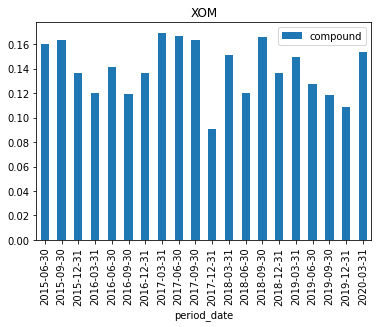

In [20]:
pd.options.mode.chained_assignment = None
df_plot = df_data[df_data['ticker'] == 'XOM'] #setting w copy warning

df_plot['period_date'] = pd.to_datetime(df_plot['period_date'])
df_plot['period_date'] = df_plot.period_date.map(lambda x: x.strftime('%Y-%m-%d')) #format

df_plot.compound = pd.to_numeric(df_plot.compound)

df_plot.plot.bar(x='period_date', y='compound', rot=90,title='XOM')
